Подключение файла Essentials, содержащего все необходимые шаблоны

In [1]:
import sys
sys.path.append("..")

import Essentials


Подключение необходимых для алгоритма библиотек, numpy понадобится всем

In [2]:
import numpy as np

from sklearn.preprocessing import StandardScaler

Загрузка данных. Есть несколько вариантов датасетов (.npz архивов), в каждом содержится несколько массивов с данными. Чтобы понять, что есть что, нужно смотреть файл Data_preparation.ipynb,
там всё закомментированно и понятно описано.

In [3]:
a = np.load('Data_Average.npz', allow_pickle=True)

Загрузка и подготовка данных. Сейчас классы построены таким образом, чтобы работать с numpy массивами X типа {N, C} и numpy массивами Y типа {N, 1}. Необходимо привести данные к такому виду для единнобразия обработки

N - количество точек, 
С - количестов каналов данных Х

In [4]:
x1 = a['X_test_1']
x2 = a['X_train_1']

y1 = a['Y_test_1']
y2 = a['Y_train_1']

In [5]:
timestamp1 = y1[:, 1]
timestamp2 = y2[:, 1]

y1 = y1[:, 0].reshape(len(y1), 1)
y1 = y1.astype(np.float64)
y2 = y2[:, 0].reshape(len(y2), 1)
y2 = y2.astype(np.float64)

Покажем, что данные действительно нужной размерности

In [6]:
y1.shape

(74, 1)

In [7]:
x1.shape

(74, 98)

Далее необходимо создать собственный класс с Виртуальным анализатором на основе шаблона SoftSensor из файла Essentials.py.

В данном случае создан тестовый вариант, модель которого заключается в вычислении тестового значения по обучающей выборке вне зависимости от вектора X тестовой выборки (по сути линейная регрессия с одним только постоянным членом в базисе).

Для правильной работы необходимо везде соблюдать нужную размерность. Описание собственного класса заключается в наследовании шаблона и переопределении всех абстрактных методов. При необходимости можно добавлять собственные методы и атрибуты

In [8]:
class TestSoftSensor(Essentials.SoftSensor):
    def __init__(self, x_train, y_train):
        super().__init__('Test')
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.x_scaler.fit(x_train)
        self.y_scaler.fit(y_train)
        self.train(x_train, y_train)

    def prepocessing(self, x):
        try:
            return self.x_scaler.transform(x)
        except:
            try:
               return self.y_scaler.transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
            

    def postprocessing(self, x):
        try:
            return self.x_scaler.inverse_transform(x)
        except:
            try:
               return self.y_scaler.inverse_transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def evaluate_model(self, x):
        preproc_x = self.prepocessing(x)
        return np.zeros([len(x), 1]) + self.get_model()


    def train(self, x_train, y_train):
        preproc_y = self.prepocessing(y_train)
        self.set_model(preproc_y.mean())


    def __str__(self):
        return f"Тестовая модель, вычисляющее среднее. Для этого экземпляра model_avg = {self.get_model()}, после постобработки avg = {self.postprocessing(self.get_model().reshape(1,1))}"

Создаём экземпляр класса с нашим алгоритмом. Имеет смысл создать по экземпляру на каждый из рассматриваемых наборов данных, данные необходимые для создания определяются в методе __init__(), там же определяется некоторые опреации, выполняемые автоматически при создании (в данном случае имя железно прописано, не делайте так, + сразу оюучаются функции для предобработки)

In [9]:
Test_sensor_1 = TestSoftSensor(x2, y2)

Пример работы метода __str__. Функция print() выдаёт нужную строку, полезно для тестирования и наглядности

In [10]:
print(Test_sensor_1)

Тестовая модель, вычисляющее среднее. Для этого экземпляра model_avg = 8.258501095457305e-16, после постобработки avg = [[57.27368421]]


Создание экземпляра метрики, достаточно одного для тестирования

In [11]:
metric = Essentials.R2Metric()

Визуализация работы алгоритма, для этого необходимо создать экземпляр класса Visualizer из Essentials.py. При создании такого экземпляра необходимо задать тестовые значения и метки X (их мы загрузили заранее), необходимо создать такой экземпляр для каждого из набора данных

In [12]:
test_visual = Essentials.Visualizer(x1, y1, timestamp1, [metric], 'Test SoftSensor R2 metric')

      Coefficient of determination
Test                     -0.004859


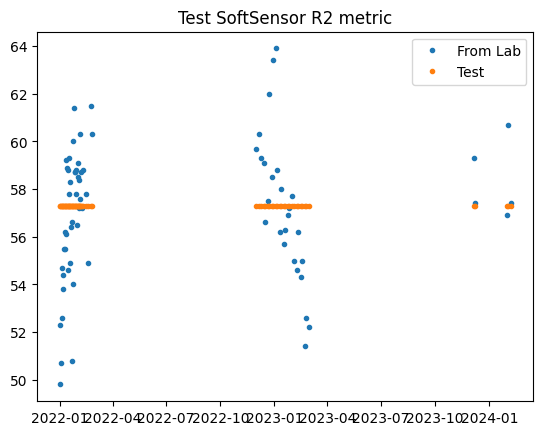

In [13]:
test_visual.visualize([Test_sensor_1])

На выходе получаем ожидаемую картинку. Тестовая модель выдаёт постоянные значения для любых Х. Значение метрики ожидаемо близко к 0 так как коэффициент детерминации сравнивает качество работы как раз со моделью среднего значения

На практике при работе в IDE рекомендуется сверху описать все необходимые классы, а тестирование производить нижу внутри конструкции 

if __name__ == '__main__':


Это точка входа в программу, которая выполняется только если запускается именно ваш файл и игнорируется, если файл импортируется. Это поможет нам избежать конфликтов и ненужных операции при импортировании моделей. Если ваша модель долго обучается, то имеет смысл описать методы save() и load() для загрузки заранее обученной модели.